# Tutorial 5: Neural Architecture Search (NAS) with Mase and Optuna

In this tutorial, we'll see how Mase can be integrated with Optuna, the popular hyperparameter optimization framework, to search for a Bert model optimized for sequence classification on the IMDb dataset. We'll take the Optuna-generated model and import it into Mase, then run the CompressionPipeline to prepare the model for edge deployment by quantizing and pruning its weights.

As we'll see, running Architecture Search with Mase/Optuna involves the following steps.

1. **Define the search space**: this is a dictionary containing the range of values for each parameter at each layer in the model.

2. **Write the model constructor**: this is a function which uses Optuna utilities to sample a model from the search space, and constructs the model using transformers from_config class method.

3. **Write the objective function**: this function calls on the model constructor defined in Step 2 and defines the training/evaluation setup for each search iteration.

4. **Go!** Choose an Optuna sampler, create a study and launch the search.

In [1]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [2]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

/Users/yz10513/anaconda3/envs/mase/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads, inspired by the [NAS-BERT paper](https://arxiv.org/abs/2105.14444).

In [3]:
import torch.nn as nn
from chop.nn.modules import Identity

search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [
        nn.Linear,
        Identity,
    ],
}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_int` and `trial.suggest_categorical` functions to trigger the chosen sampler to choose parameter choices and layer types. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [4]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr


def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # Update the paramaters in the config
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        setattr(config, param, search_space[param][chosen_idx])

    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [5]:
from chop.tools import get_trainer


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    # Set the model as an attribute so we can fetch it later
    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

Optuna provides a number of samplers, for example:

* **GridSampler**: iterates through every possible combination of hyperparameters in the search space
* **RandomSampler**: chooses a random combination of hyperparameters in each iteration
* **TPESampler**: uses Tree-structured Parzen Estimator algorithm to choose hyperparameter values.

You can define the chosen sampler by simply importing from `optuna.samplers` as below.

In [6]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

With all the pieces in place, we can launch the search as follows. The number of trials is set to 1 so you can go get a coffee for 10 minutes, then proceed with the tutorial. However, this will essentially be a random model - for better results, set this to 100 and leave it running overnight!

In [7]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=1,
    timeout=60 * 60 * 24,
)

[I 2024-12-01 22:51:50,104] A new study created in memory with name: bert-tiny-nas-study
/Users/yz10513/anaconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/yz10513/anaconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/Users/yz10513/anaconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> whic

[2024-12-01 22:51:52,032] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to mps (auto detect)


W1201 22:51:52.945000 8580182592 torch/distributed/elastic/multiprocessing/redirects.py:27] NOTE: Redirects are currently not supported in Windows or MacOs.
 16%|█▌        | 500/3125 [00:44<03:42, 11.81it/s]

{'loss': 0.668, 'grad_norm': 4.309191703796387, 'learning_rate': 4.2e-05, 'epoch': 0.16}


 32%|███▏      | 1000/3125 [01:28<05:01,  7.06it/s]

{'loss': 0.5047, 'grad_norm': 23.95120620727539, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.32}


 48%|████▊     | 1500/3125 [02:13<01:41, 16.07it/s]

{'loss': 0.4092, 'grad_norm': 12.666841506958008, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.48}


 64%|██████▍   | 2000/3125 [02:52<01:49, 10.28it/s]

{'loss': 0.3682, 'grad_norm': 21.01616859436035, 'learning_rate': 1.8e-05, 'epoch': 0.64}


 80%|████████  | 2500/3125 [03:25<00:38, 16.24it/s]

{'loss': 0.3396, 'grad_norm': 19.34454917907715, 'learning_rate': 1e-05, 'epoch': 0.8}


 96%|█████████▌| 3000/3125 [03:59<00:08, 14.06it/s]

{'loss': 0.3538, 'grad_norm': 21.48626708984375, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.96}


100%|██████████| 3125/3125 [04:07<00:00, 12.60it/s]


{'train_runtime': 247.935, 'train_samples_per_second': 100.833, 'train_steps_per_second': 12.604, 'train_loss': 0.4358914270019531, 'epoch': 1.0}


100%|██████████| 3125/3125 [03:58<00:00, 13.08it/s]
[I 2024-12-01 23:00:00,199] Trial 0 finished with value: 0.86256 and parameters: {'num_layers': 2, 'num_heads': 1, 'hidden_size': 3, 'intermediate_size': 3, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.module

Fetch the model associated with the best trial as follows, and export to be used in future tutorials. In Tutorial 6, we'll see how to run mixed-precision quantization search on top of the model we've just found through NAS to further find the optimal quantization mapping.

In [8]:
from pathlib import Path
import dill

model = study.best_trial.user_attrs["model"].cpu()

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "wb") as f:
    dill.dump(model, f)

## Deploying the Optimized Model with CompressionPipeline

Now, we can run the CompressionPipeline in Mase to run uniform quantization and pruning over the searched model.

In [ ]:
from chop.pipelines import CompressionPipeline
from chop import MaseGraph

mg = MaseGraph(model)
pipe = CompressionPipeline()

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

mg, _ = pipe(
    mg,
    pass_args={
        "quantize_transform_pass": quantization_config,
        "prune_transform_pass": pruning_config,
    },
)

Finally, export the MaseGraph for the compressed checkpoint to be used in future tutorials for hardware generation and distributed deployment.

In [ ]:
mg.export(f"{Path.home()}/tutorial_5_nas_compressed")

# Task 1

In [ ]:
import torch.nn as nn
from chop.nn.modules import Identity
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr
from chop.tools import get_tokenized_dataset, get_trainer
import optuna
from optuna.samplers import GridSampler, TPESampler, RandomSampler
import matplotlib.pyplot as plt
import dill
import pandas as pd


import os

def log_trial_results_to_csv(trial, eval_results, csv_filename="search_results.csv"):
    """Logs trial parameters and results to a CSV file."""
    trial_data = {
        "trial_number": trial.number,
        "accuracy": eval_results["eval_accuracy"],
        **trial.params,  # Include all parameter values
    }

    df = pd.DataFrame([trial_data])

    # Check if the file exists, if not, create it with headers
    if not os.path.exists(csv_filename):
        df.to_csv(csv_filename, index=False)
    else:
        df.to_csv(csv_filename, mode='a', header=False, index=False)

    print(f"Trial {trial.number} results saved to {csv_filename}")


# checkpoint and dataset

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

# Load tokenized dataset and tokenizer
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

#search space
grid_search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [
        nn.Linear,
        Identity,
    ],
}

tpe_search_space = grid_search_space  # Using the same search space for consistency


# define each model for each of the trials

def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # Map trial parameters to BERT config
    config.num_hidden_layers = trial.suggest_categorical("num_layers", grid_search_space["num_layers"])
    config.num_attention_heads = trial.suggest_categorical("num_heads", grid_search_space["num_heads"])
    config.hidden_size = trial.suggest_categorical("hidden_size", grid_search_space["hidden_size"])
    config.intermediate_size = trial.suggest_categorical("intermediate_size", grid_search_space["intermediate_size"])

    model = AutoModelForSequenceClassification.from_config(config)

    # Handle linear layer choice
    linear_choice = trial.suggest_categorical("linear_layer_choices", grid_search_space["linear_layer_choices"])

    if linear_choice == "identity":
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
                deepsetattr(model, name, Identity())  # Replace with Identity layer

    return model

# -----------------------------
# 4. Define the objective function
# -----------------------------


def objective(trial):
    try:
        trial_model = construct_model(trial)

        trainer = get_trainer(
            model=trial_model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=1,   # Reduced for demonstration
        )

        trainer.train()
        eval_results = trainer.evaluate()

        # Save the trial configuration and accuracy for logging
        trial.set_user_attr("model", trial_model)
        trial.set_user_attr("accuracy", eval_results["eval_accuracy"])
        trial.set_user_attr("params", trial.params)

        # Log trial results to CSV
        log_trial_results_to_csv(trial, eval_results)

        return eval_results["eval_accuracy"]
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        return None


# records the results of the trials in a csv file
def run_study_and_log_results(sampler, n_trials, study_name="study"):
    study = optuna.create_study(
        direction="maximize",
        study_name=study_name,
        sampler=sampler,
    )

    study.optimize(
        objective,
        n_trials=n_trials,
        timeout=60 * 10 * 24,   # 10-minute timeout for demonstration
        show_progress_bar=True,
    )

    # Save trial results to a CSV file
    trial_results = []
    for trial in study.trials:
        trial_results.append({
            "trial_number": trial.number,
            "accuracy": trial.value,
            **trial.params,  # Include all parameter values
        })

    # Convert to DataFrame and save
    df = pd.DataFrame(trial_results)
    csv_filename = f"{study_name}_results.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Results saved to {csv_filename}")

    return study, trial_results

# -----------------------------
# 6. Compare GridSampler, TPESampler, and RandomSampler
# -----------------------------
if __name__ == "__main__":
    # Define samplers
    grid_sampler = GridSampler(
        search_space={
            "num_layers": grid_search_space["num_layers"],
            "num_heads": grid_search_space["num_heads"],
            "hidden_size": grid_search_space["hidden_size"],
            "intermediate_size": grid_search_space["intermediate_size"],
            "linear_layer_choices": grid_search_space["linear_layer_choices"],
        }
    )


    tpe_sampler = TPESampler()

    
    random_sampler = RandomSampler()

    # Run experiments
    n_trials = 15

    # Run GridSampler study and log results
    grid_study, grid_results = run_study_and_log_results(
        sampler=grid_sampler,
        n_trials=n_trials,
        study_name="bert-grid-study"
    )
    print(f"[GridSampler] Best accuracy: {grid_study.best_value:.4f}")

    # Run TPESampler study and log results
    tpe_study, tpe_results = run_study_and_log_results(
        sampler=tpe_sampler,
        n_trials=n_trials,
        study_name="bert-tpe-study"
    )
    print(f"[TPESampler] Best accuracy: {tpe_study.best_value:.4f}")

    # Run RandomSampler study and log results
    random_study, random_results = run_study_and_log_results(
        sampler=random_sampler,
        n_trials=n_trials,
        study_name="bert-random-study"
    )
    print(f"[RandomSampler] Best accuracy: {random_study.best_value:.4f}")

    # -----------------------------
    # 7. Plot the results
    # -----------------------------
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(grid_results)+1), [r["accuracy"] for r in grid_results], label="GridSampler", marker="o")
    plt.plot(range(1, len(tpe_results)+1), [r["accuracy"] for r in tpe_results], label="TPESampler", marker="x")
    plt.plot(range(1, len(random_results)+1), [r["accuracy"] for r in random_results], label="RandomSampler", marker="s")
    plt.xlabel("Number of Trials")
    plt.ylabel("Max Accuracy So Far")
    plt.title("Comparison of Samplers")
    plt.legend()
    plt.grid()
    plt.show()

    # -----------------------------
    # 8. Save the best models and configurations
    # -----------------------------
    best_grid_model = grid_study.best_trial.user_attrs["model"].cpu()
    best_grid_params = grid_study.best_trial.user_attrs["params"]
    with open("best_grid_model.pkl", "wb") as f:
        dill.dump(best_grid_model, f)
    with open("best_grid_config.txt", "w") as f:
        f.write(str(best_grid_params))

    best_tpe_model = tpe_study.best_trial.user_attrs["model"].cpu()
    best_tpe_params = tpe_study.best_trial.user_attrs["params"]
    with open("best_tpe_model.pkl", "wb") as f:
        dill.dump(best_tpe_model, f)
    with open("best_tpe_config.txt", "w") as f:
        f.write(str(best_tpe_params))

    best_random_model = random_study.best_trial.user_attrs["model"].cpu()
    best_random_params = random_study.best_trial.user_attrs["params"]
    with open("best_random_model.pkl", "wb") as f:
        dill.dump(best_random_model, f)
    with open("best_random_config.txt", "w") as f:
        f.write(str(best_random_params))

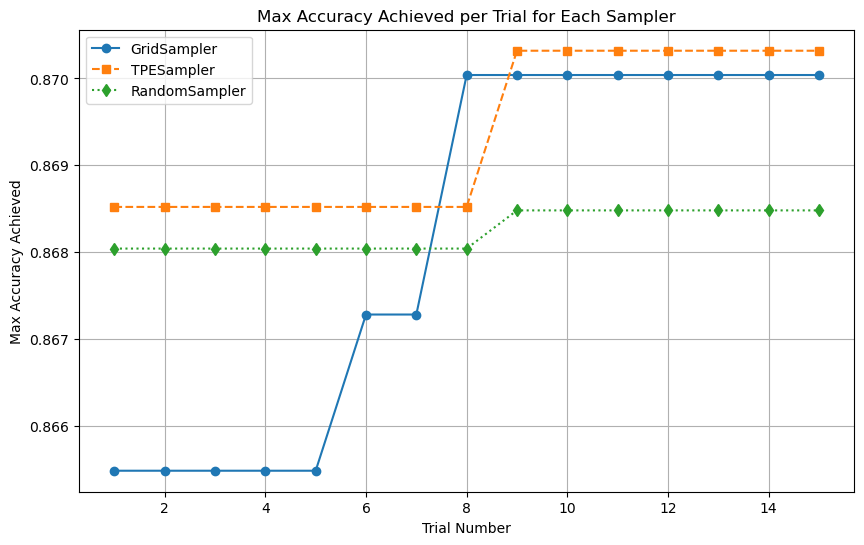

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define the accuracy values for each sampler
accuracies_grid = [0.86548, 0.85796, 0.8512, 0.86308, 0.8618, 0.86728, 0.86244, 0.87004, 0.86628, 0.85632, 0.86212, 0.86792, 0.85392, 0.86044, 0.83896]
accuracies_tpe = [0.86852, 0.8652, 0.852, 0.86444, 0.85396, 0.86152, 0.84784, 0.8468, 0.87032, 0.85144, 0.86944, 0.86944, 0.86944, 0.86244, 0.86844]
accuracies_random = [0.86804, 0.86596, 0.8548, 0.85632, 0.85792, 0.85172, 0.85936, 0.85836, 0.86848, 0.8678, 0.86596, 0.86672, 0.84068, 0.8494, 0.85184]

# Compute the cumulative max values
max_grid = np.maximum.accumulate(accuracies_grid)
max_tpe = np.maximum.accumulate(accuracies_tpe)
max_random = np.maximum.accumulate(accuracies_random)

# Create a trial index
trials = np.arange(1, 16)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(trials, max_grid, label='GridSampler', marker='o', linestyle='-')
plt.plot(trials, max_tpe, label='TPESampler', marker='s', linestyle='--')
plt.plot(trials, max_random, label='RandomSampler', marker='d', linestyle=':')

plt.xlabel('Trial Number')
plt.ylabel('Max Accuracy Achieved')
plt.title('Max Accuracy Achieved per Trial for Each Sampler')
plt.legend()
plt.grid()
plt.show()


# Extra Test

Understand the effect of more training epochs on the best model obtained from random samper:

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from chop.tools import get_trainer
import torch
from pathlib import Path
import dill






# Load the best model using dill
model_path = "/content/best_random_model.pkl"

with open(model_path, "rb") as f:
    best_model = dill.load(f)





# Define number of extra epochs
extra_epochs = 8  # Change this if you want more or fewer training cycles

# Dictionary to store accuracy after each epoch
results_log = []

# Variable to track the best model
best_val_accuracy = 0.0
best_model_path = "best_random_model_best.pkl"

# Training loop (Train -> Evaluate -> Repeat)
for epoch in range(1, extra_epochs + 1):
    print(f"\n🚀 Training Epoch {epoch}/{extra_epochs}...\n")

    # Create a new trainer for each epoch
    trainer = get_trainer(
        model=best_model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,  # Only train for 1 epoch at a time
    )

    # Train for one epoch
    trainer.train()

    # Evaluate after training
    eval_results = trainer.evaluate()
    val_accuracy = eval_results["eval_accuracy"]  # Validation Accuracy
    test_accuracy = eval_results["test_accuracy"] if "test_accuracy" in eval_results else None  # Test Accuracy

    # Save results for logging
    results_log.append({
        "epoch": epoch,
        "validation_accuracy": val_accuracy,
        "test_accuracy": test_accuracy
    })

    # Check if the model achieved the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(best_model, best_model_path)  # Save the best model
        print(f"🎯 New best model saved at {best_model_path} with validation accuracy: {best_val_accuracy:.4f}")

    print(f"✅ Epoch {epoch}: Validation Accuracy = {val_accuracy:.4f}, Test Accuracy = {test_accuracy}")

# Save results to a CSV file
csv_file_path = "training_results.csv"
df_results = pd.DataFrame(results_log)
df_results.to_csv(csv_file_path, index=False)
print(f"\n📂 Results saved to {csv_file_path}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df_results["epoch"], df_results["validation_accuracy"], marker="o", label="Validation Accuracy")
if "test_accuracy" in df_results.columns and df_results["test_accuracy"].notna().any():
    plt.plot(df_results["epoch"], df_results["test_accuracy"], marker="s", label="Test Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation and Test Accuracy Progression")
plt.legend()
plt.grid(True)
plt.show()


![alt text](Tutorial%20Images/Tutorial%205/TestingMoreEpochs.png)


In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from chop.tools import get_trainer
import dill

# Load the best model using dill
model_path = "/content/best_tpe_model.pkl"

with open(model_path, "rb") as f:
    best_model = dill.load(f)

# Define the total number of epochs and step size
total_epochs = 2.0  
epoch_step = 0.1  # Train in increments of 0.1 epoch

# Dictionary to store accuracy after each step
results_log = []

# Variable to track the best model
best_val_accuracy = 0.0
best_model_path = "/content/best_tpe_model.pkl"

# Perform initial evaluation (before any training)
trainer = get_trainer(
    model=best_model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
    num_train_epochs=0,  # No training, just evaluation
)
eval_results = trainer.evaluate()
val_accuracy = eval_results["eval_accuracy"]
test_accuracy = eval_results.get("test_accuracy", None)

# Log the initial evaluation
results_log.append({
    "epoch": 0.0,
    "validation_accuracy": val_accuracy,
    "test_accuracy": test_accuracy
})

print(f"🟢 Initial Model Evaluation: Validation Accuracy = {val_accuracy:.4f}, Test Accuracy = {test_accuracy}")

# Training loop with increments of 0.1 epoch
current_epoch = 0.0

while current_epoch < total_epochs:
    current_epoch += epoch_step  # Increase epoch step

    print(f"\n🚀 Training Epoch {current_epoch:.1f}/{total_epochs}...\n")

    # Create a trainer for training with the best model so far
    trainer = get_trainer(
        model=best_model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=epoch_step,  # Train for 0.1 epoch at a time
    )

    # Train for 0.1 epoch
    trainer.train()

    # Update `best_model` with the trained weights
    best_model = trainer.model  

    # Evaluate after training
    eval_results = trainer.evaluate()
    val_accuracy = eval_results["eval_accuracy"]
    test_accuracy = eval_results.get("test_accuracy", None)

    # Save results for logging
    results_log.append({
        "epoch": round(current_epoch, 1),
        "validation_accuracy": val_accuracy,
        "test_accuracy": test_accuracy
    })

    # Check if the model achieved the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(best_model, best_model_path)  # ✅ Save the new best model
        print(f"🎯 New best model saved at {best_model_path} with validation accuracy: {best_val_accuracy:.4f}")

    print(f"✅ Epoch {current_epoch:.1f}: Validation Accuracy = {val_accuracy:.4f}, Test Accuracy = {test_accuracy}")

# Save results to a CSV file
csv_file_path = "training_results.csv"
df_results = pd.DataFrame(results_log)
df_results.to_csv(csv_file_path, index=False)
print(f"\n📂 Results saved to {csv_file_path}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df_results["epoch"], df_results["validation_accuracy"], marker="o", label="Validation Accuracy")
if "test_accuracy" in df_results.columns and df_results["test_accuracy"].notna().any():
    plt.plot(df_results["epoch"], df_results["test_accuracy"], marker="s", label="Test Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation and Test Accuracy Progression (0.1 Epoch Increments)")
plt.legend()
plt.grid(True)
plt.show()

![alt text](Tutorial%20Images/Tutorial%205/SmallEpochValidationTest.png)


# Task 2

Code to compare baseline, compression with no post training and compression with post training

In [ ]:
import optuna
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModelForSequenceClassification
import pandas as pd

def save_study_results_to_csv(study, filename):
    trials_data = []
    for trial in study.get_trials(deepcopy=False):
        trials_data.append({
            "trial_number": trial.number,
            "value": trial.value,
            "params": trial.params,
            "user_attrs": trial.user_attrs,
        })
    df = pd.DataFrame(trials_data)
    df.to_csv(filename, index=False)

# ---------------------------
# 1) PREPARE DATA + TRAINER
# ---------------------------
from chop.tools import get_tokenized_dataset, get_trainer, deepsetattr
from chop.pipelines import CompressionPipeline
from chop import MaseGraph
from chop.nn.modules import Identity

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

# ---------------------------
# 2) DEFINE SEARCH SPACE
# ---------------------------
search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [nn.Linear, Identity],
}

def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)
    for param in ["num_layers", "num_heads", "hidden_size", "intermediate_size"]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        setattr(config, param, search_space[param][chosen_idx])
    trial_model = AutoModelForSequenceClassification.from_config(config)
    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(f"{name}_type", search_space["linear_layer_choices"])
            if new_layer_cls == Identity:
                deepsetattr(trial_model, name, Identity())
    return trial_model

# ---------------------------
# 3) BASELINE (NO COMPRESSION)
# ---------------------------
def objective_baseline(trial):
    model = construct_model(trial)
    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer.train()
    eval_results = trainer.evaluate()
    final_acc = eval_results["eval_accuracy"]
    trial.set_user_attr("model", model)
    return final_acc

study_baseline = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-baseline-tpe",
    sampler=TPESampler(seed=0),
)
study_baseline.optimize(objective_baseline, n_trials=10, timeout=60*30*30)
save_study_results_to_csv(study_baseline, "baseline_study_results.csv")
best_baseline_model = study_baseline.best_trial.user_attrs["model"]
best_baseline_model.save_pretrained("best_baseline_model")

# ---------------------------
# 4) COMPRESSION‐AWARE (NO POST‐TRAIN)
# ---------------------------
class HuggingFaceCompatibleModel(nn.Module):
    def __init__(self, compressed_model):
        super().__init__()
        self.compressed_model = compressed_model

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.compressed_model(input_ids=input_ids)
        logits = outputs["logits"] if isinstance(outputs, dict) else outputs
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
        return {"loss": loss, "logits": logits}

def objective_compress_no_post(trial):
    quantization_config = {
        "by": "type",
        "default": {"config": {"name": None}},
        "linear": {
            "config": {
                "name": "integer",
                "data_in_width": 8, "data_in_frac_width": 4,
                "weight_width": 8, "weight_frac_width": 4,
                "bias_width": 8, "bias_frac_width": 4,
            }
        },
    }
    pruning_config = {
        "weight": {"sparsity": 0.5, "method": "l1-norm", "scope": "local"},
        "activation": {"sparsity": 0.5, "method": "l1-norm", "scope": "local"},
    }

    model = construct_model(trial)
    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer.train()
    model.to("cpu")
    mg = MaseGraph(model)
    mg, _ = CompressionPipeline()(mg, pass_args={
        "quantize_transform_pass": quantization_config,
        "prune_transform_pass": pruning_config,
    })
    wrapped_model = HuggingFaceCompatibleModel(mg.model).to("cuda")
    trainer_eval = get_trainer(
        model=wrapped_model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=0,
    )
    final_acc = trainer_eval.evaluate()["eval_accuracy"]
    trial.set_user_attr("model", wrapped_model)
    return final_acc

study_compress_no_post = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-compression-no-post",
    sampler=TPESampler(seed=1),
)
study_compress_no_post.optimize(objective_compress_no_post, n_trials=10, timeout=60*30*30)
save_study_results_to_csv(study_compress_no_post, "compress_no_post_study_results.csv")
best_trial = study_compress_no_post.best_trial
wrapped_model = best_trial.user_attrs["model"]
torch.save(wrapped_model.compressed_model.state_dict(), "best_compress_no_post_model.pt")

# ---------------------------
# 5) COMPRESSION‐AWARE (WITH POST‐TRAIN)
# ---------------------------
def objective_compress_with_post(trial):
    quantization_config = {
        "by": "type",
        "default": {"config": {"name": None}},
        "linear": {
            "config": {
                "name": "integer",
                "data_in_width": 8, "data_in_frac_width": 4,
                "weight_width": 8, "weight_frac_width": 4,
                "bias_width": 8, "bias_frac_width": 4,
            }
        },
    }
    pruning_config = {
        "weight": {"sparsity": 0.5, "method": "l1-norm", "scope": "local"},
        "activation": {"sparsity": 0.5, "method": "l1-norm", "scope": "local"},
    }

    model = construct_model(trial)
    trainer_pre = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer_pre.train()
    model.to("cpu")
    mg = MaseGraph(model)
    mg, _ = CompressionPipeline()(mg, pass_args={
        "quantize_transform_pass": quantization_config,
        "prune_transform_pass": pruning_config,
    })
    wrapped_model = HuggingFaceCompatibleModel(mg.model.to("cuda"))
    trainer_post = get_trainer(
        model=wrapped_model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=3,
    )
    trainer_post.train()
    final_acc = trainer_post.evaluate()["eval_accuracy"]
    trial.set_user_attr("model", wrapped_model)
    return final_acc

study_compress_with_post = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-compression-with-post",
    sampler=TPESampler(seed=2),
)
study_compress_with_post.optimize(objective_compress_with_post, n_trials=10, timeout=60*30*30)
save_study_results_to_csv(study_compress_with_post, "compress_with_post_study_results.csv")
best_trial = study_compress_with_post.best_trial
wrapped_model = best_trial.user_attrs["model"]
torch.save(wrapped_model.compressed_model.state_dict(), "best_compress_with_post_model.pt")

# ---------------------------
# 6) PLOT RESULTS
# ---------------------------
def get_best_so_far(study):
    best_so_far = []
    current_max = float("-inf")
    for t in study.get_trials(deepcopy=False):
        current_max = max(current_max, t.value) if t.value is not None else current_max
        best_so_far.append(current_max)
    return best_so_far

plt.figure(figsize=(10, 6))
plt.plot(get_best_so_far(study_baseline), label="Baseline (no compression)", marker="o")
plt.plot(get_best_so_far(study_compress_no_post), label="Compression-Aware (no post-train)", marker="s")
plt.plot(get_best_so_far(study_compress_with_post), label="Compression-Aware (with post-train)", marker="^")
plt.xlabel("Trial Number")
plt.ylabel("Best Accuracy Achieved")
plt.title("NAS Performance Comparison with Compression Awareness")
plt.legend()
plt.grid(True)
plt.savefig("nas_comparison_plot.png")
plt.show()

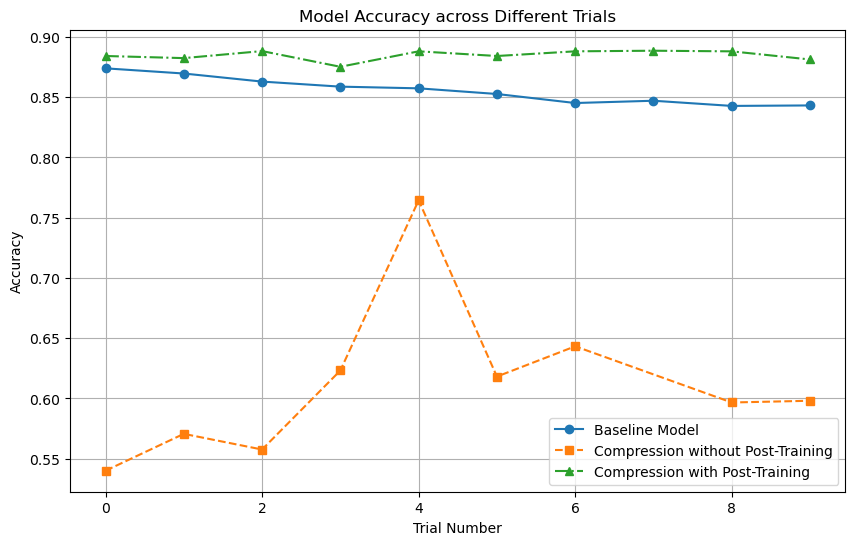

In [23]:
import re
import matplotlib.pyplot as plt

# Log data

# Log data
log_data = """
Trial 0 finished with value: 0.8740 Baseline Model
Trial 1 finished with value: 0.8697 Baseline Model
Trial 2 finished with value: 0.8630 Baseline Model
Trial 3 finished with value: 0.8588 Baseline Model
Trial 4 finished with value: 0.8574 Baseline Model
Trial 5 finished with value: 0.8527 Baseline Model
Trial 6 finished with value: 0.8452 Baseline Model
Trial 7 finished with value: 0.8471 Baseline Model
Trial 8 finished with value: 0.8428 Baseline Model
Trial 9 finished with value: 0.8432 Baseline Model
Trial 0 finished with value: 0.53996 Compression without Post-Training
Trial 1 finished with value: 0.57056 Compression without Post-Training
Trial 2 finished with value: 0.55756 Compression without Post-Training
Trial 3 finished with value: 0.62316 Compression without Post-Training
Trial 4 finished with value: 0.76444 Compression without Post-Training
Trial 5 finished with value: 0.61812 Compression without Post-Training
Trial 6 finished with value: 0.64324 Compression without Post-Training
Trial 8 finished with value: 0.5966 Compression without Post-Training
Trial 9 finished with value: 0.59804 Compression without Post-Training
Trial 0 finished with value: 0.88424 Compression with Post-Training
Trial 1 finished with value: 0.88248 Compression with Post-Training
Trial 2 finished with value: 0.88832 Compression with Post-Training
Trial 3 finished with value: 0.87528 Compression with Post-Training
Trial 4 finished with value: 0.88812 Compression with Post-Training
Trial 5 finished with value: 0.88424 Compression with Post-Training
Trial 6 finished with value: 0.88812 Compression with Post-Training
Trial 7 finished with value: 0.88862 Compression with Post-Training
Trial 8 finished with value: 0.88810 Compression with Post-Training
Trial 9 finished with value: 0.88134 Compression with Post-Training

"""

# Extract data using regex
baseline_trials, baseline_accuracies = [], []
compression_trials, compression_accuracies = [], []
post_training_trials, post_training_accuracies = [], []

matches = re.findall(r"Trial (\d+) finished with value: (\d+\.\d+) (Baseline Model|Compression without Post-Training|Compression with Post-Training)", log_data)

for match in matches:
    trial_num = int(match[0])
    accuracy = float(match[1])
    category = match[2]

    if category == "Baseline Model":
        baseline_trials.append(trial_num)
        baseline_accuracies.append(accuracy)
    elif category == "Compression without Post-Training":
        compression_trials.append(trial_num)
        compression_accuracies.append(accuracy)
    elif category == "Compression with Post-Training":
        post_training_trials.append(trial_num)
        post_training_accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(baseline_trials, baseline_accuracies, label="Baseline Model", marker='o', linestyle='-')
plt.plot(compression_trials, compression_accuracies, label="Compression without Post-Training", marker='s', linestyle='--')
plt.plot(post_training_trials, post_training_accuracies, label="Compression with Post-Training", marker='^', linestyle='-.')

plt.xlabel("Trial Number")
plt.ylabel("Accuracy")
plt.title("Model Accuracy across Different Trials")
plt.legend()
plt.grid(True)

plt.show()


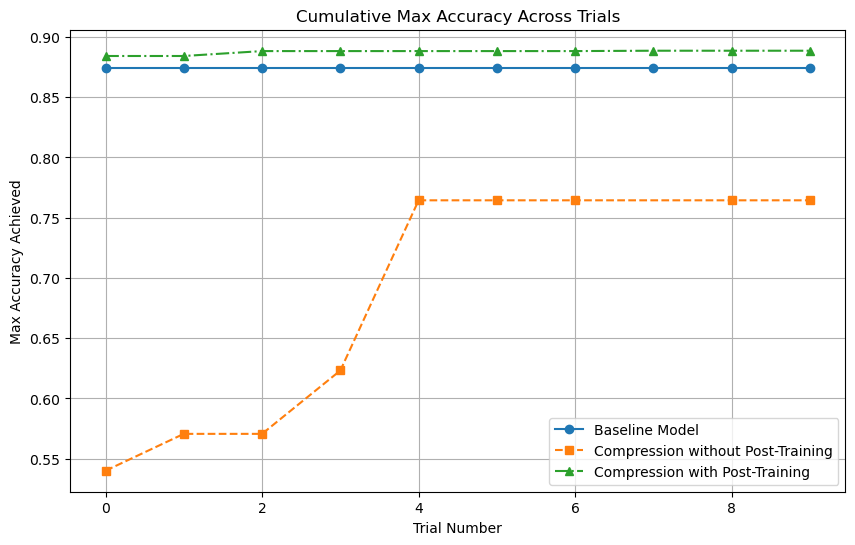

In [24]:
import re
import matplotlib.pyplot as plt

# Extract trial numbers, accuracy values, and categories
trials_baseline = []
accuracies_baseline = []
trials_compression = []
accuracies_compression = []
trials_post_training = []
accuracies_post_training = []

matches = re.findall(r"Trial (\d+) finished with value: (\d+\.\d+) (Baseline Model|Compression without Post-Training|Compression with Post-Training)", log_data)

for match in matches:
    trial_num = int(match[0])
    accuracy = float(match[1])
    category = match[2]

    if category == "Baseline Model":
        trials_baseline.append(trial_num)
        accuracies_baseline.append(accuracy)
    elif category == "Compression without Post-Training":
        trials_compression.append(trial_num)
        accuracies_compression.append(accuracy)
    elif category == "Compression with Post-Training":
        trials_post_training.append(trial_num)
        accuracies_post_training.append(accuracy)

# Compute cumulative maximum accuracy for each trial type
max_baseline = [max(accuracies_baseline[:i+1]) for i in range(len(accuracies_baseline))]
max_compression = [max(accuracies_compression[:i+1]) for i in range(len(accuracies_compression))]
max_post_training = [max(accuracies_post_training[:i+1]) for i in range(len(accuracies_post_training))]

# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(trials_baseline, max_baseline, label="Baseline Model", marker='o', linestyle='-')
plt.plot(trials_compression, max_compression, label="Compression without Post-Training", marker='s', linestyle='--')
plt.plot(trials_post_training, max_post_training, label="Compression with Post-Training", marker='^', linestyle='-.')

plt.xlabel("Trial Number")
plt.ylabel("Max Accuracy Achieved")
plt.title("Cumulative Max Accuracy Across Trials")
plt.legend()
plt.grid(True)

plt.show()
